In [1]:
import pandas as pd
import numpy as np
import cvxpy as cp
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

In [2]:
import Soccer
class soccer_env:
## THIS IS A WRAPPER BASED ON THE SOCCER GAME ENVIROMENT DEVELOPED BY ZENGLIX
## https://github.com/zengliX/SoccerGame
    def __init__(self):
        self.soccer = Soccer.World()
    
    def move(self, actions):
        a_map = {0:'N',
        1:'E', 
        2:'S',
        3:'W',
        4:'0'}
        p1, p2 =  self.soccer.take_both_actions("A", a_map[actions[0]], "B", a_map[actions[1]])

        p1_pos = p1[0]* 4 +  p1[1]
        p2_pos = p2[0]* 4 +  p2[1]
        ball = (0 if p1[3]==True else 1) 
        
        r1 = p1[2]
        r2 = p2[2]
        done = p1[4]&p2[4]
        state = [p1_pos, p2_pos, ball]
        reward = [r1, r2]
        
        return state, reward, done*1

# Multi-agent Q-learning

In [3]:
def get_action(Q, state, epsilon):
    
    if np.random.random()<epsilon:
        action = np.random.randint(n_action)
    else: 
        action = np.argmax(Q[state[0],state[1],state[2],:])
        
    return action

In [4]:
np.random.seed(0)

n_state_A, n_state_B, n_state_ball = 8,8,2
n_action = 5
q_space = (n_state_A, n_state_B, n_state_ball, n_action)

gamma = 0.9

epsilon = 1
epsilon_min = 0.001
epsilon_decay = 0.999995

alpha = 1.0
alpha_min = 0.001
alpha_decay = 0.999995

T = 1000000

## Initialize
V1 = np.zeros(n_state_A)
V2 = np.zeros(n_state_B)

Q1 = np.zeros(q_space)
Q2 = np.zeros(q_space)

error1= []


n = 0
while n <= T:
        
    env = soccer_env()
    state = env.move([4,4])[0]
    done = 0
    while not done:
        
        if n%100000 == 0:
            print(n)
        
        action = [get_action(Q1, state, epsilon), get_action(Q2, state, epsilon)]
        
        ## perform actions:
        state_prime, reward, done = env.move(action)
        n+=1
        
        Q1_copy = Q1[2,1,1,2]

        # for i in 2:
        if not done:
            V1[state_prime[0]] = max(Q1[state_prime[0],state_prime[1],state_prime[2],:]) 
            V2[state_prime[1]] = max(Q2[state_prime[0],state_prime[1],state_prime[2],:]) 
        else:
            V1[state_prime[0]] = 0
            V2[state_prime[1]] = 0
        
        Q1[state[0], state[1], state[2], action[0]] = (1-alpha) * Q1[state[0], state[1], state[2], action[0]] + alpha * ((1-gamma)*reward[0] + gamma*V1[state_prime[0]])
        Q2[state[0], state[1], state[2], action[1]] = (1-alpha) * Q2[state[0], state[1], state[2], action[1]] + alpha * ((1-gamma)*reward[1] + gamma*V2[state_prime[1]])

        error1.append(abs(Q1[2,1,1,2] - Q1_copy))    
        
        state = state_prime
        
        alpha = max(alpha*alpha_decay, alpha_min)
        epsilon = max(epsilon*epsilon_decay, epsilon_min)
        
        if done:
            break
            
            

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


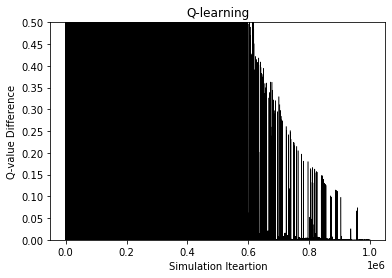

In [5]:
plt.plot(error1, color = 'black', linewidth=0.5)
plt.xlabel('Simulation Iteartion')
plt.ylabel('Q-value Difference')
plt.ylim(0,0.5)
plt.yticks(np.arange(0,0.51,0.05))
plt.title('Q-learning')
plt.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
# plt.savefig('fig1.png')
# plt.clf()

# Friend-Q

In [6]:
def friend_get_joint_action(Q, state, epsilon):
    
    
    if np.random.random()<epsilon:
        joint_action = (np.random.randint(n_action), np.random.randint(n_action))
    else: 
        a = Q[state[0],state[1],state[2],:,:]
        joint_action = np.unravel_index(a.argmax(), a.shape)
        
    return joint_action

In [7]:
np.random.seed(0)

n_state_A, n_state_B, n_state_ball = 8,8,2
n_action = 5
q_space = (n_state_A, n_state_B, n_state_ball, n_action, n_action)

gamma = 0.9

epsilon = 1
epsilon_min = 0.001
epsilon_decay = 0.999995

alpha = 0.2
alpha_min = 0.001
alpha_decay = 0.99997

T = 1000000

## Initialize
V1 = np.zeros(n_state_A)
V2 = np.zeros(n_state_B)

Q1 = np.zeros(q_space)
Q2 = np.zeros(q_space)

error1= []

# Q learning

n = 0
while n <= T:
        
    env = soccer_env()
    state = env.move([4,4])[0]
    done = 0
    while not done:
        
        if n%100000 == 0:
            print(n)
        
        action = [friend_get_joint_action(Q1, state, epsilon)[0], friend_get_joint_action(Q2, state, epsilon)[1]]
        
        ## perform actions:
        state_prime, reward, done = env.move(action)
        n+=1
        
        Q1_copy = Q1[2,1,1,2,4]
        
        if not done:
            V1[state_prime[0]] = np.max(Q1[state_prime[0],state_prime[1],state_prime[2],:]) 
            V2[state_prime[1]] = np.max(Q2[state_prime[0],state_prime[1],state_prime[2],:]) 
        else:
            V1[state_prime[0]] = 0
            V2[state_prime[1]] = 0
        
        Q1[state[0], state[1], state[2], action[0], action[1]] = (1-alpha) * Q1[state[0], state[1], state[2], action[0], action[1]] + alpha * ((1-gamma)*reward[0] + gamma*V1[state_prime[0]])
        Q2[state[0], state[1], state[2], action[0], action[1]] = (1-alpha) * Q2[state[0], state[1], state[2], action[0], action[1]] + alpha * ((1-gamma)*reward[1] + gamma*V2[state_prime[1]])

        error1.append(abs(Q1[2,1,1,2,4] - Q1_copy))
        
        state = state_prime
        
        alpha = max(alpha*alpha_decay, alpha_min)
        epsilon = max(epsilon*epsilon_decay, epsilon_min)
        
        if done:
            break
            
            

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


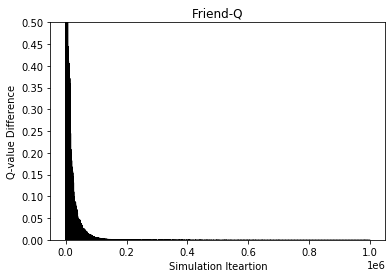

In [8]:
plt.plot(error1, color = 'black', linewidth=0.5)
plt.xlabel('Simulation Iteartion')
plt.ylabel('Q-value Difference')
plt.ylim(0,0.5)
plt.yticks(np.arange(0,0.51,0.05))
plt.title('Friend-Q')
plt.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
# plt.savefig('fig2.png')
# plt.clf()

# Foe-Q

In [325]:
def get_V_pi(Q, state):
    R = Q[state[0], state[1], state[2]] ##5 o action * 5 your action

    x = cp.Variable(n_action)
    V = cp.min(R @ x) ## maximize it
    prob = cp.Problem(cp.Maximize(V),
                     [x >= 0,
                      cp.sum(x) ==1])
    prob.solve()

    opt_V = prob.value
    opt_x = x.value.round(10).clip(min=0)
    opt_x = opt_x/sum(opt_x)
    
    return opt_V, opt_x

def foe_get_action(Q, state, epsilon, pi):
    ## assume the other one is doing the worst
    if np.random.random()<epsilon:
        action = np.random.randint(n_action)
    else: 
        action = np.random.choice(possible_actions, 1, p = pi[state[0], state[1], state[2]])[0]
        
    return action

In [327]:
np.random.seed(0)

possible_actions = [0,1,2,3,4]
n_state_A, n_state_B, n_state_ball = 8,8,2
n_action = 5
q_space = (n_state_A, n_state_B, n_state_ball, n_action, n_action)
pi_space = (n_state_A, n_state_B, n_state_ball, n_action)
V_space = (n_state_A, n_state_B, n_state_ball)

# for everey state, there's a pi
pi_A = [1/n_action] * np.ones(pi_space)
pi_B = [1/n_action] * np.ones(pi_space)

gamma = 0.9

epsilon = 1
epsilon_min = 0.001
epsilon_decay = 0.99995

alpha = 1
alpha_min = 0.001
alpha_decay = 0.99995

T = 1000000

## Initialize
V1 = np.ones(V_space)
V2 = np.ones(V_space)

Q1 = np.ones(q_space)
Q2 = np.ones(q_space)

error1= []

n = 0
while n <= T:
        
    env = soccer_env()
    state = env.move([4,4])[0]
    done = 0
    #For T steps:
    while not done:

        
        if n%10000 == 0:
            print(n)
        
        action = [foe_get_action(Q1, state, epsilon, pi_A), foe_get_action(Q2, state, epsilon, pi_B)]
        
        ## perform actions:
        state_prime, reward, done = env.move(action)
        n+=1
        
        Q1_copy = Q1[2,1,1,4,2]


        #action[1]: player B, your oppoent;  action[0]: player A, your self
        Q1[state[0], state[1], state[2], action[1], action[0]] = (1-alpha) * Q1[state[0], state[1], state[2], action[1], action[0]] + alpha * ((1-gamma)*reward[0] + gamma*V1[state_prime[0],state_prime[1],state_prime[2]])
        Q2[state[0], state[1], state[2], action[0], action[1]] = (1-alpha) * Q2[state[0], state[1], state[2], action[0], action[1]] + alpha * ((1-gamma)*reward[1] + gamma*V2[state_prime[0],state_prime[1],state_prime[2]])
        
        
        ######################LP#########################
        # x: for each state, get the optimal action probalility that will maximize V, 
        # where V is a min reward that O can control

        opt_V1, opt_pi_A = get_V_pi(Q1, state)
        opt_V2, opt_pi_B = get_V_pi(Q2, state)
        ######################LP#########################
        
        
        if not done:
            V1[state[0],state[1],state[2]] = opt_V1
            V2[state[0],state[1],state[2]] = opt_V2
        else:
            V1[state[0],state[1],state[2]] = 0
            V2[state[0],state[1],state[2]] = 0
            
            
        pi_A[state[0], state[1], state[2]] = opt_pi_A
        pi_B[state[0], state[1], state[2]] = opt_pi_B 
        
        error1.append(abs(Q1[2,1,1,4,2] - Q1_copy))    
        
        state = state_prime
        
        alpha = max(alpha*alpha_decay, alpha_min)
        epsilon = max(epsilon*epsilon_decay, epsilon_min)
        
        if done:
            break
            
            

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000


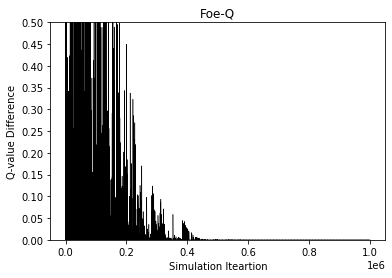

In [336]:
plt.plot(error1, color = 'black', linewidth=0.5)
plt.xlabel('Simulation Iteartion')
plt.ylabel('Q-value Difference')
plt.ylim(0,0.5)
plt.yticks(np.arange(0,0.51,0.05))
plt.title('Foe-Q')
plt.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
# plt.savefig('fig3.png')
# plt.clf()

## uCE

In [4]:
def uCE_get_action(state, epsilon, pi): 
    ## get the joint action based on probability
    if np.random.random()<epsilon:
        action = (np.random.randint(n_action),np.random.randint(n_action))
    else: 
        p = pi[state[0], state[1], state[2], ].flatten()
        action_index = np.random.choice(range(n_action*n_action), 1, p = p)[0]
        action = np.unravel_index(action_index, (n_action,n_action)) # my action then opponents'
    return action 

In [5]:
def get_V_pi_CE(Q1, Q2, state):

    R1 = Q1[state[0], state[1], state[2]] 
    R2 = Q2[state[0], state[1], state[2]] # A first, then B

    G = np.zeros((40, 25))
    r = 0
    for i in range(n_action):
        for j in range(n_action):
            if i != j:
                G[r, i*n_action:(i+1)*n_action] = R1[j,:] - R1[i,:]
                G[r+n_action*(n_action-1), i:(n_action*n_action):n_action] =  R2[:,j] -  R2[:,i]
                r+=1
                
    G3 = - np.eye(25)
    G = matrix(np.vstack((G,G3)))


    c = matrix((R1 + R2).reshape(25))
    h = matrix(np.zeros(65) * 0.0)
    A = matrix(np.ones((1, 25)))
    b = matrix(1.0)
    
    prob = solvers.lp(c=c, G=G, h=h, A=A, b=b,solver='glpk')
    result_x = np.array(prob['x'])

    if prob['x'] is not None and not np.isnan(result_x).any():
        opt_x = result_x.reshape((5,5)).round(10).clip(min=0) ## row as player A and col as player B
        opt_x=opt_x/(opt_x).sum()

        opt_V1 = (opt_x * R1).sum()
        opt_V2 = (opt_x * R2).sum()


    else: 
        opt_x, opt_V1, opt_V2 = None, None, None
        
    return opt_V1, opt_V2, opt_x

In [9]:
np.random.seed(0)
## CE learning

T = 1000000
possible_actions = np.array([0,1,2,3,4])
n_state_A, n_state_B, n_state_ball = 8,8,2
n_action = 5
q_space = (n_state_A, n_state_B, n_state_ball, n_action, n_action) ## Player A's action, then B's action 
pi_space = (n_state_A, n_state_B, n_state_ball, n_action, n_action) 
V_space = (n_state_A, n_state_B, n_state_ball) 

# for everey state, there's a pi
pi_joint = [1/(n_action*n_action)] * np.ones(pi_space) ## Player A's action, then B's action 


gamma = 0.9

epsilon = 1
epsilon_min = 0.001
epsilon_decay = 0.99995

alpha = 1
alpha_min = 0.001
alpha_decay = 0.99995

## Initialize
V1 = np.ones(V_space)
V2 = np.ones(V_space)

Q1 = np.ones(q_space)
Q2 = np.ones(q_space)
error1= []

# Q learning
solvers.options['glpk'] = {'msg_lev': 'GLP_MSG_OFF','tm_lim': 1000}
n = 0
while n <= T:
        
    env = soccer_env()
    state = env.move([4,4])[0]
    done = 0
    #For T steps:
    while not done:

        
        if n%10000 == 0:
            print(n)
            
        action = uCE_get_action(state, epsilon, pi_joint)
        
        ## perform actions:
        state_prime, reward, done = env.move(action)
        n+=1
        
        Q1_copy = Q1[2,1,1,2,4] ## player A and player B

        #action[1]: player B, your oppoent;  action[0]: player A, your self
        Q1[state[0], state[1], state[2], action[0], action[1]] = (1-alpha) * Q1[state[0], state[1], state[2], action[0], action[1]] + alpha * ((1-gamma)*reward[0] + gamma*V1[state_prime[0],state_prime[1],state_prime[2]])
        Q2[state[0], state[1], state[2], action[0], action[1]] = (1-alpha) * Q2[state[0], state[1], state[2], action[0], action[1]] + alpha * ((1-gamma)*reward[1] + gamma*V2[state_prime[0],state_prime[1],state_prime[2]])
        
        
        ######################LP#########################
        # x: for each state, get the optimal action probalility that will maximize V, 
        # where V is a min reward that O can control    
        opt_V1, opt_V2, opt_pi = get_V_pi_CE(Q1, Q2, state) ## player A on the row, player B on col
        ######################LP#########################
        
        if opt_pi is not None:
            if not done:
                V1[state[0],state[1],state[2]] = opt_V1
                V2[state[0],state[1],state[2]] = opt_V2
            else:
                V1[state[0],state[1],state[2]] = 0
                V2[state[0],state[1],state[2]] = 0
            
            pi_joint[state[0], state[1], state[2]] = opt_pi 
        
        error1.append(abs(Q1[2,1,1,2,4] - Q1_copy))    
        state = state_prime
        
        alpha = max(alpha*alpha_decay, alpha_min)
        epsilon = max(epsilon*epsilon_decay, epsilon_min)
        
        if done:
            break
            
            

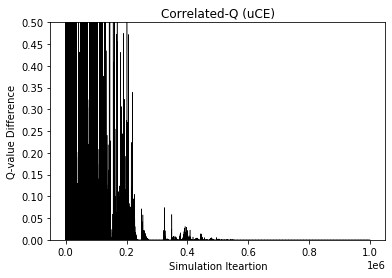

In [42]:
plt.plot(error1, color = 'black', linewidth=0.5)
plt.xlabel('Simulation Iteartion')
plt.ylabel('Q-value Difference')
plt.ylim(0,0.5)
plt.yticks(np.arange(0,0.51,0.05))
plt.title('Correlated-Q (uCE)')
plt.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
# plt.savefig('fig4.png')
# plt.clf()